# Test-Retest reliabity on functional connectivity:
# To what extent FCD identifies an individual?

In [112]:
from __future__ import division
import pandas as pd
import numpy as np
import seaborn as sns
from os.path import join as opj
from matplotlib import pyplot as plt
import scipy
from polyML import polyssifier_3 as ps
from polyML import bootstrap_tools as bt
from polyML import TON_tools
%matplotlib inline
from sklearn.preprocessing import StandardScaler

sns.set_style('darkgrid')

Let's start by loading the FCD data

In [9]:
mname = ('/data2/polo/code/MLtool/TON_resting_classification/proc_data/'
         'non_smooth_non_subsamp/thres07/'
         'TON_Resting_State_bct_degrees_log_norm_median.mat')
out_dir = '/data2/polo/figures'
do_save = False

data, labels = ps.load_data(mname)[:2]
subject_list = ps.load_subject_list(mname, source='matlab')


In [15]:
runs_per_subj = data.shape[0] // subject_list.shape[0]
assert np.remainder(data.shape[0], subject_list.shape[0]) == 0

In [17]:
scaler = StandardScaler()
test = scaler.fit_transform(data[::runs_per_subj, :])
retest = scaler.transform(data[1::runs_per_subj, :])

In [38]:
corrs = np.zeros(subject_list.shape)
corr_mat = np.zeros(subject_list.shape * 2)
for six in range(corrs.shape[0]):
    corrs[six] = scipy.stats.pearsonr(test[six, :], retest[six, :])[0]
    for sjx in range(corrs.shape[0]):
        corr_mat[six, sjx] = scipy.stats.pearsonr(test[six, :], retest[sjx, :])[0]


Let's plot the correlation matrix between test and retest across subjects. As it is expected from a high reliability measure,it is dominated by the diagonal.

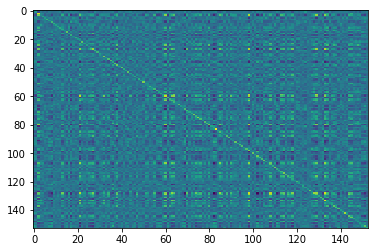

In [39]:
plt.imshow(corr_mat, aspect='auto', interpolation='nearest')

If we wanted to idenify someone by a FCD retest sample, we could compute the correlation between all the test samples and this retest retest sample, and pick the identity of the test ID that maximally correlates with the retest sample.
What would be the success rate of this simple identification method?

In [1]:
100 * (corr_mat.argmax(axis=0) == np.arange(subject_list.shape[0])).sum() / subject_list.shape[0]

NameError: name 'corr_mat' is not defined

More generally, how does the test sample of the true ID rank in terms of correlation with the retest sample? What is the chance expectation?

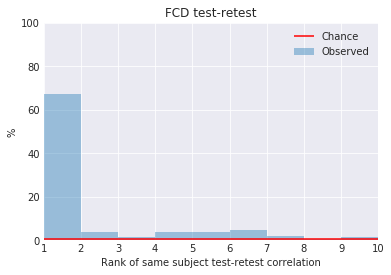

In [148]:
rank_corrs = (-corr_mat).argsort(axis=1)
z = np.argwhere(rank_corrs == np.arange(rank_corrs.shape[0])[:, None])[:, 1]
fh, ah = plt.subplots(1)
#ds, bins, bars = ah.hist(z, bins=np.arange(z.shape[0]), density=True)
sns.distplot(z+1, bins=np.arange(z.shape[0]), kde=False, norm_hist=True)
ah.set_xlim([1, 10])
ah.set_ylim([0, 1])
ah.set_yticklabels((ah.get_yticks() * 100).astype(int))
ah.hlines(1/z.shape[0], *ah.get_xlim(), colors='r')
ah.legend(['Chance', 'Observed'])
ah.set_xlabel('Rank of same subject test-retest correlation')
ah.set_ylabel('%')
ah.set_title('FCD test-retest')
if do_save:
    fh.savefig(opj(out_dir, 'consistency_ranks.pdf'))